In [2]:
import sys; sys.path.append('..') # add project root to the python path

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.part2.tensorized_dp import TensorDP
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [4]:
nx = 5
ny = 5
env = GridworldEnv([ny, nx])

## 동적계획법 '에이전트' 초기화하기

동적 게획법은 원래 `에이전트`라는 개념을 사용하지 않지만, 일반적으로 사용되는 강화학습의 구현 템플릿에 대한 이해를 돕기 위해 `에이전트`라는 개념을 적용하였습니다.

In [5]:
dp_agent = TensorDP()
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Num. state = 25 | Num. actions = 4 


## 정책 반복

정책반복 : (정책 평가 + 정책 개선)을 정책이 수렴할때까지 반복!

<img src="./images/policy_iteration.png" width="80%" height="50%" title="px(픽셀) 크기 설정" alt="Tensor"></img>

```python
def policy_iteration(self, policy=None):
    if policy is None:
        pi_old = self.policy
    else:
        pi_old = policy

    info = dict()
    info['v'] = list()
    info['pi'] = list()
    info['converge'] = None

    steps = 0
    converged = False
    while True:
        v_old = self.policy_evaluation(pi_old)
        pi_improved = self.policy_improvement(pi_old, v_old)
        steps += 1

        info['v'].append(v_old)
        info['pi'].append(pi_old)

        # check convergence
        policy_gap = np.linalg.norm(pi_improved - pi_old)

        if policy_gap <= self.error_tol:
            if not converged:  # record the first moment of within error tolerance.
                info['converge'] = steps
            break
        else:
            pi_old = pi_improved
    return info
```

In [6]:
%%time
dp_agent.reset_policy()
info_pi = dp_agent.policy_iteration()

CPU times: user 4.17 ms, sys: 199 µs, total: 4.37 ms
Wall time: 3.06 ms


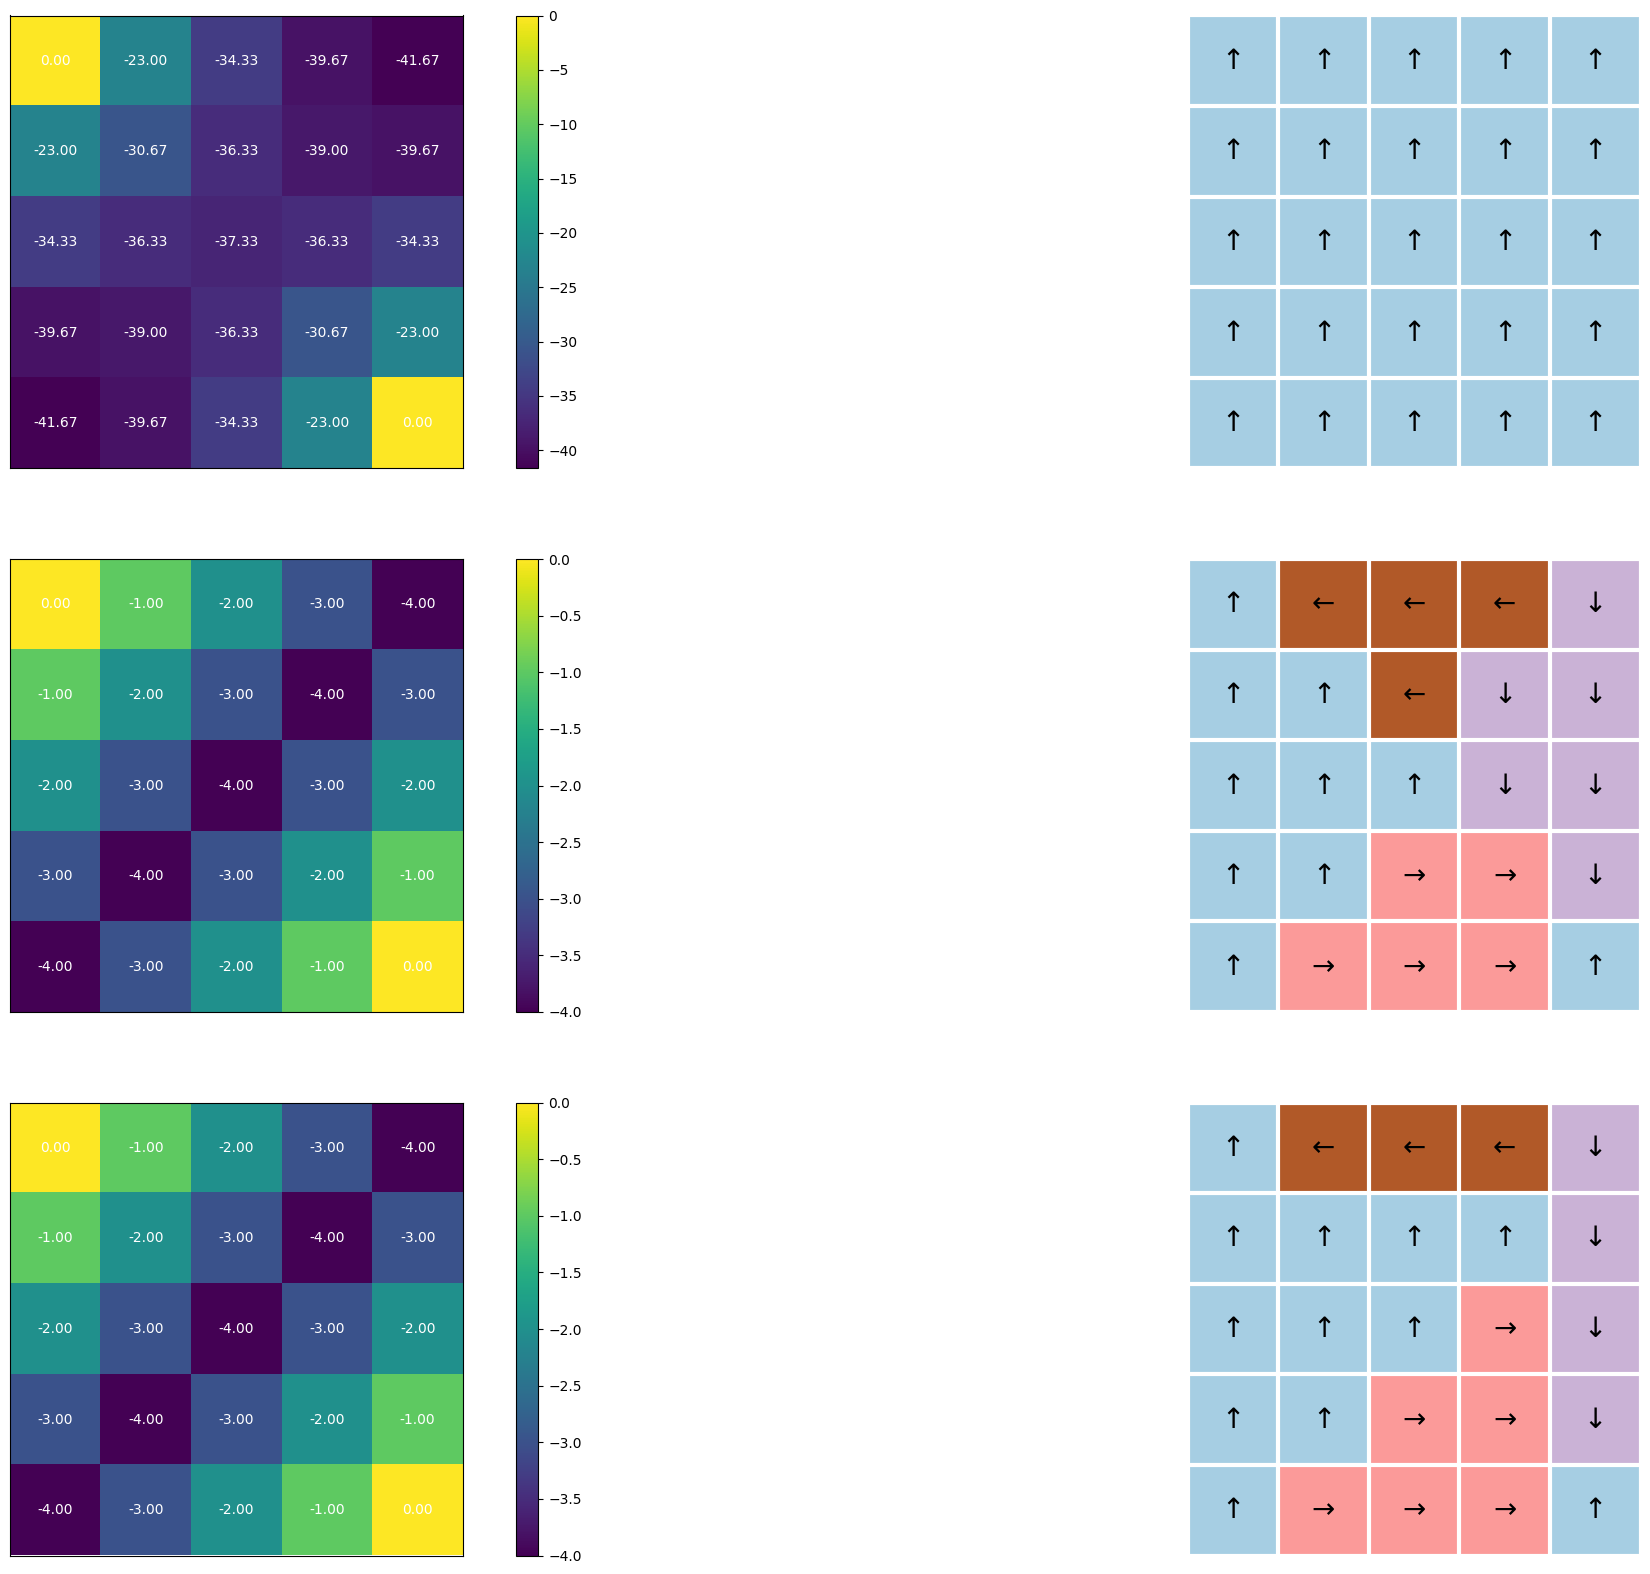

In [7]:
figsize_mul = 10
steps = info_pi['converge']

fig, ax = plt.subplots(nrows=steps, ncols=2, figsize=(steps * figsize_mul, 
                                         figsize_mul * 2))


for i in range(steps):
    visualize_value_function(ax[i][0],info_pi['v'][i], nx, ny)
    visualize_policy(ax[i][1], info_pi['pi'][i], nx, ny)    

## 가치 반복

<img src="./images/value_iter.png" width="80%" height="50%" title="px(픽셀) 크기 설정" alt="Tensor"></img>

```python
def value_iteration(self, v_init=None, compute_pi=False):
    """
    :param v_init: (np.array) initial value 'guesstimation' (optional)
    :param compute_pi: (bool) compute policy during VI
    :return: v_opt: the optimal value function
    """

    if v_init is not None:
        v_old = v_init
    else:
        v_old = np.zeros(self.ns)

    info = dict()
    info['v'] = list()
    info['pi'] = list()
    info['converge'] = None

    steps = 0
    converged = False

    while True:
        # Bellman optimality backup
        v_improved = (self.R.T + self.P.dot(v_old)).max(axis=0) # [num. actions x num states]
        info['v'].append(v_improved)

        if compute_pi:
            # compute policy from v
            # 1) Compute v -> q
            q_pi = (self.R.T + self.P.dot(v_improved)) # [num. actions x num states]

            # 2) Construct greedy policy
            pi = np.zeros_like(self.policy)
            pi[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1
            info['pi'].append(pi)

        steps += 1

        # check convergence
        value_gap = np.linalg.norm(v_improved - v_old)

        if value_gap <= self.error_tol:
            if not converged:  # record the first moment of within error tolerance.
                info['converge'] = steps
            break
        else:
            v_old = v_improved
    return info
    ```

In [8]:
%%time
dp_agent.reset_policy()
info_vi = dp_agent.value_iteration(compute_pi=True)

CPU times: user 530 µs, sys: 558 µs, total: 1.09 ms
Wall time: 661 µs


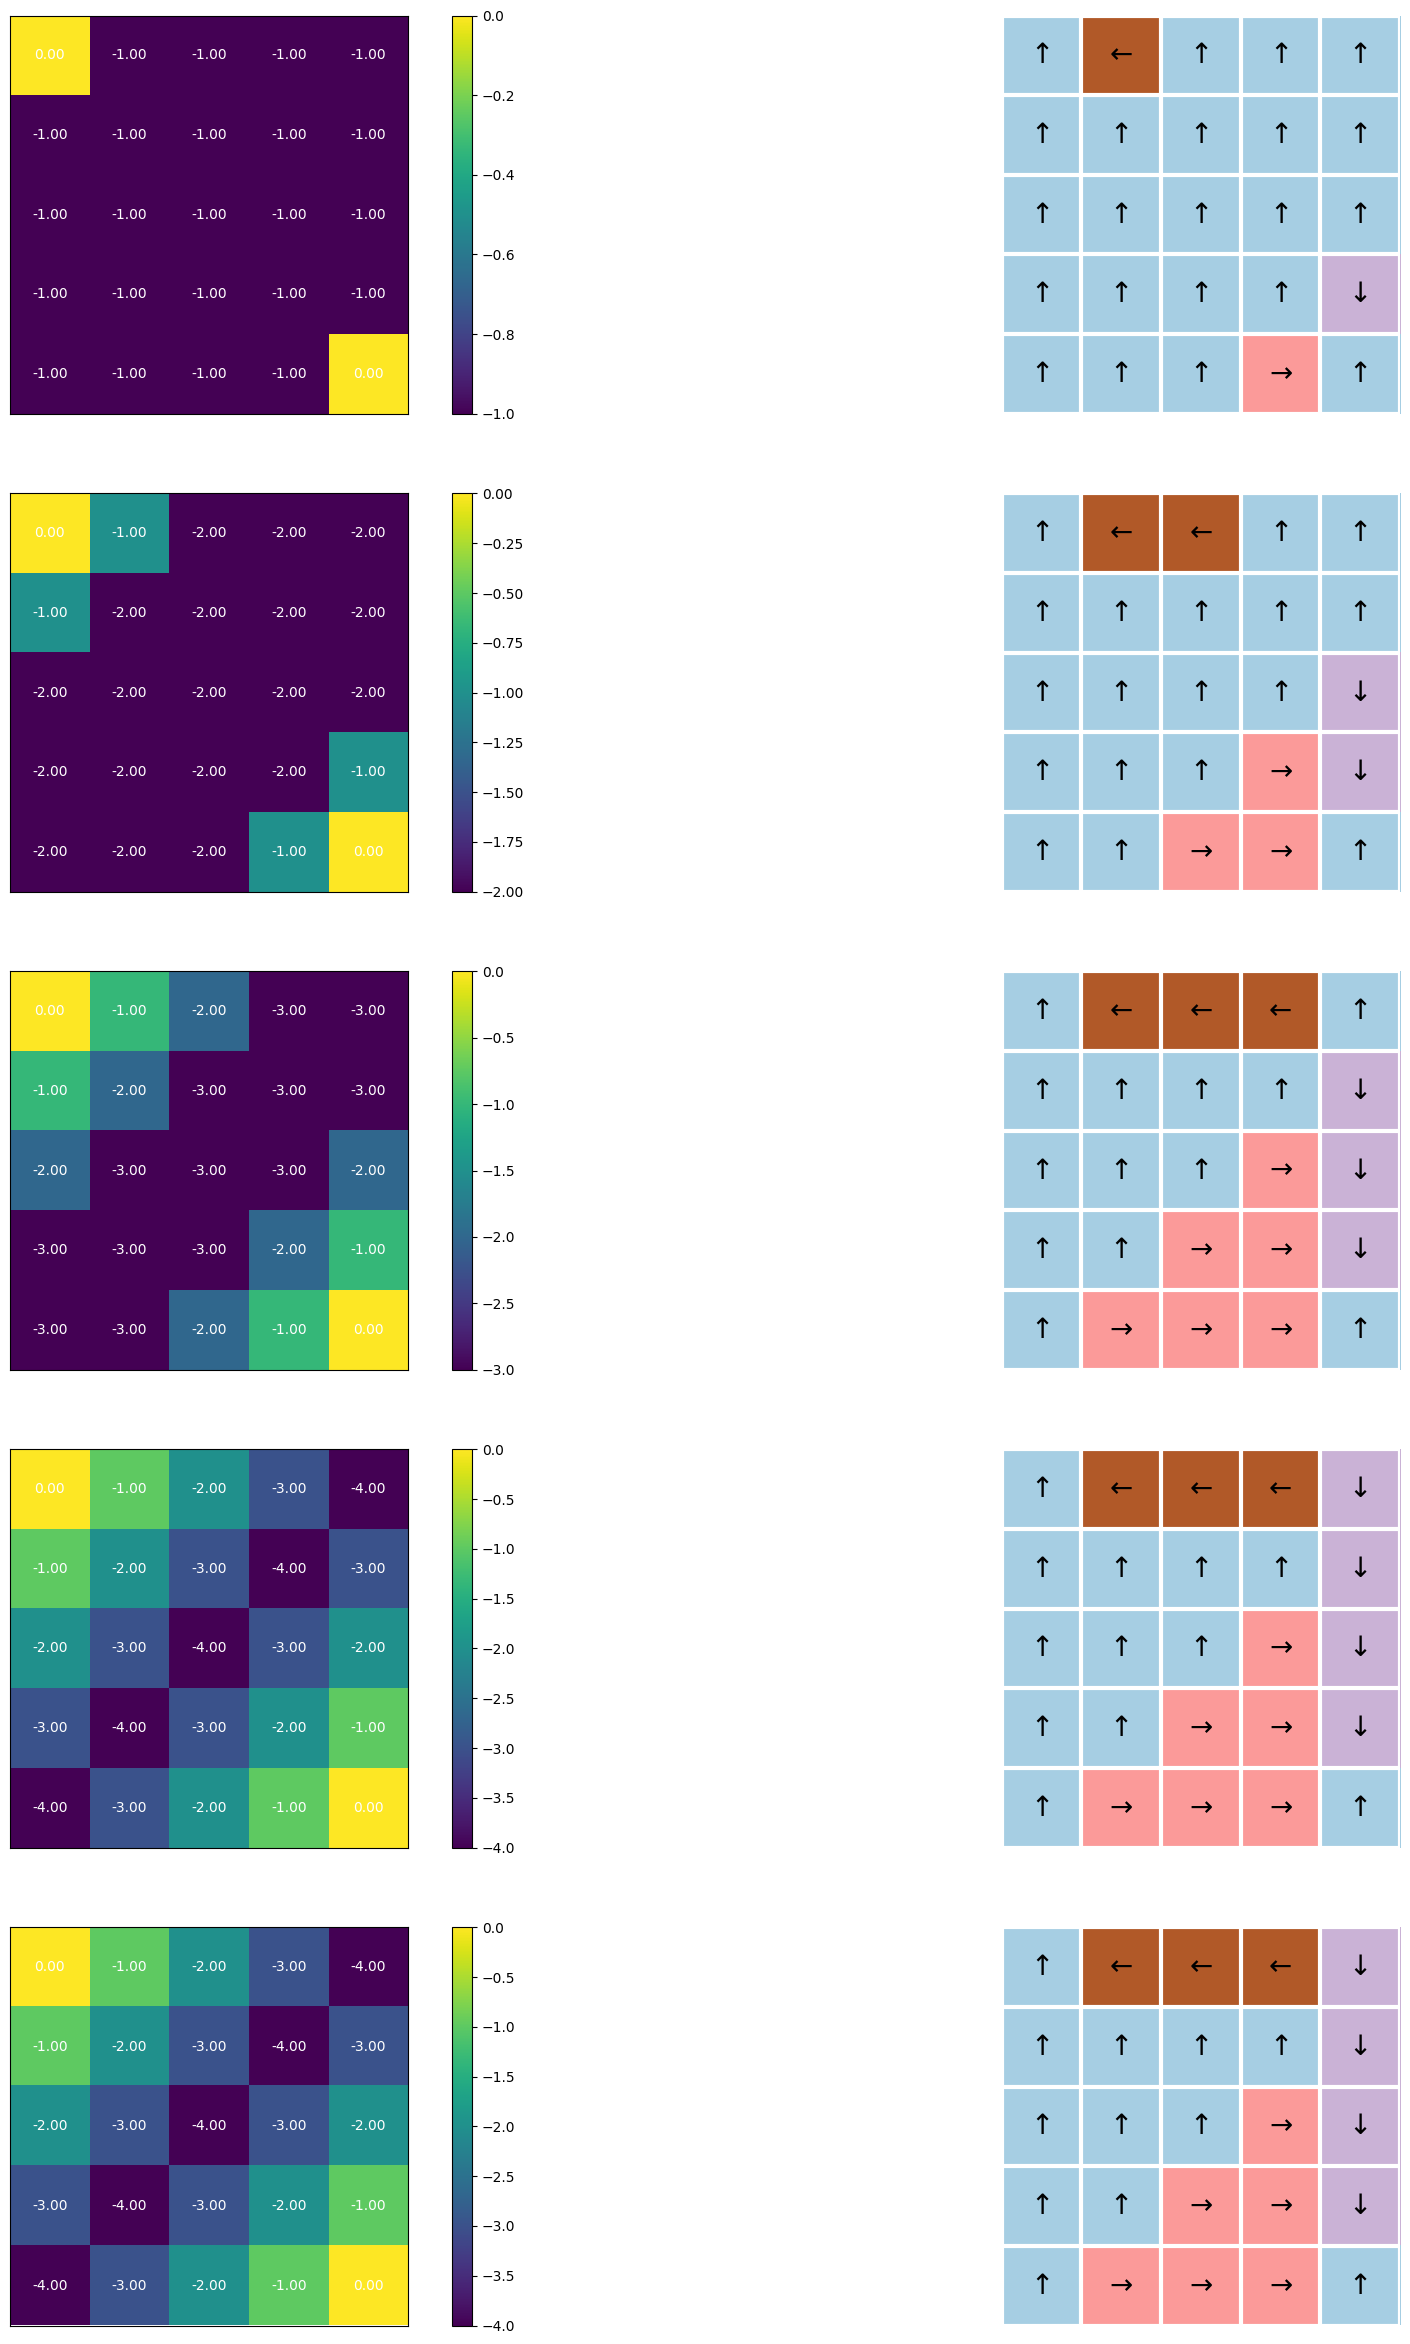

In [9]:
figsize_mul = 10
steps = info_vi['converge']

fig, ax = plt.subplots(nrows=steps,ncols=2, figsize=(steps * figsize_mul * 0.5, figsize_mul* 3))
for i in range(steps):
    visualize_value_function(ax[i][0],info_vi['v'][i], nx, ny)
    visualize_policy(ax[i][1], info_vi['pi'][i], nx, ny)    